In [5]:
import pandas as pd
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.visualization.petri_net import visualizer as pn_visualizer 

import os

In [2]:
def load_training_data():
    # Get the base simulated_data directory
    base_dir = "../simulated_data"
    training_dfs = []
    
    # Check if directory exists
    if not os.path.exists(base_dir):
        print(f"Directory {base_dir} does not exist")
        return training_dfs
        
    # Iterate through each folder in simulated_data
    for folder in os.listdir(base_dir):
        folder_path = os.path.join(base_dir, folder)
        
        # Check if it's a directory and contains main_results
        main_results_path = os.path.join(folder_path, "autonomous")
        if os.path.isdir(folder_path) and os.path.exists(main_results_path):
            
            # Look for train_preprocessed.csv
            train_file = os.path.join(main_results_path, "train_preprocessed.csv")
            if os.path.exists(train_file):
                try:
                    # Read the CSV file
                    df = pd.read_csv(train_file)
                    
                    # Store the dataframe with folder name for reference
                    training_dfs.append({
                        "folder": folder,
                        "data": df
                    })
                    print(f"Loaded training data from {folder}")
                except Exception as e:
                    print(f"Error loading {train_file}: {str(e)}")
    
    return training_dfs

In [3]:
dfs= load_training_data()

Loaded training data from synthetic_log
Loaded training data from Confidential_2000
Loaded training data from ConsultaDataMining
Loaded training data from BPIC_2012_W
Loaded training data from Confidential_1000
Loaded training data from running_example
Loaded training data from P2P
Loaded training data from BPIC_2017_W
Loaded training data from Production
Loaded training data from LoanApp.csv
Loaded training data from cvs_pharmacy


In [4]:
def rename_dataframe_columns(training_dfs):
    # Column mapping dictionary
    column_map = {
        'end_timestamp': 'time:timestamp',
        'case_id': 'case:concept:name',
        'activity_name': 'concept:name',  # Note: using activity_name based on your codebase
        'activity': 'concept:name'  # Including both variations to be safe
    }
    
    logs = []
    # Iterate through each dataset
    for dataset in training_dfs:
        # Rename columns that exist in the DataFrame
        existing_columns = {old: new for old, new in column_map.items() 
                          if old in dataset['data'].columns}
        
        # Apply the renaming
        dataset['data'].rename(columns=existing_columns, inplace=True)
        
        print(f"Renamed columns in {dataset['folder']}")
        print(f"New columns: {dataset['data'].columns.tolist()}")

        dataset['data']['start_timestamp'] = pd.to_datetime(dataset['data']['start_timestamp'], format='mixed')
        dataset['data']['time:timestamp'] = pd.to_datetime(dataset['data']['time:timestamp'], format='mixed')

        # dataset['data'] = dataframe_utils.convert_timestamp_columns_in_df(dataset['data'])
        log = log_converter.apply(dataset['data'])
        logs.append(log)
    return logs
logs= rename_dataframe_columns(dfs)

Renamed columns in synthetic_log
New columns: ['case:concept:name', 'concept:name', 'resource', 'start_timestamp', 'time:timestamp', 'agent']
Renamed columns in Confidential_2000
New columns: ['Unnamed: 0', 'elementId', 'processId', 'concept:name', 'lifecycle:transition', 'time:timestamp', 'case:concept:name', 'case:LogType', 'resourceId', 'resource', 'start_timestamp', 'agent']
Renamed columns in ConsultaDataMining
New columns: ['Unnamed: 0', 'concept:name', 'lifecycle:transition', 'resource', 'time:timestamp', 'Activity', 'Resource', 'case:concept:name', 'case:variant', 'case:variant-index', 'case:creator', 'start_timestamp', 'agent']
Renamed columns in BPIC_2012_W
New columns: ['Unnamed: 0', 'concept:name', 'lifecycle:transition', 'org:resource', 'time:timestamp', 'concept:name', 'resource', 'case:concept:name', 'case:variant', 'case:variant-index', 'case:creator', 'start_timestamp', 'agent']


/opt/homebrew/anaconda3/envs/agent_simulator/lib/python3.9/site-packages/pm4py/util/pandas_utils.py:53: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  return df.to_dict('records')


Renamed columns in Confidential_1000
New columns: ['Unnamed: 0', 'elementId', 'processId', 'concept:name', 'lifecycle:transition', 'time:timestamp', 'case:concept:name', 'case:LogType', 'resourceId', 'resource', 'start_timestamp', 'agent']
Renamed columns in running_example
New columns: ['time:timestamp', 'concept:name', 'case:concept:name', 'resource', 'transition_id', 'start_timestamp', 'agent']
Renamed columns in P2P
New columns: ['Unnamed: 0', 'concept:name', 'lifecycle:transition', 'org:resource', 'time:timestamp', 'Activity', 'resource', 'case:concept:name', 'case:variant', 'case:variant-index', 'case:creator', 'start_timestamp', 'agent']
Renamed columns in BPIC_2017_W
New columns: ['Unnamed: 0', 'concept:name', 'lifecycle:transition', 'resource', 'time:timestamp', 'Activity', 'Resource', 'case:concept:name', 'case:variant', 'case:variant-index', 'case:creator', 'start_timestamp', 'agent']
Renamed columns in Production
New columns: ['case:concept:name', 'concept:name', 'resource'

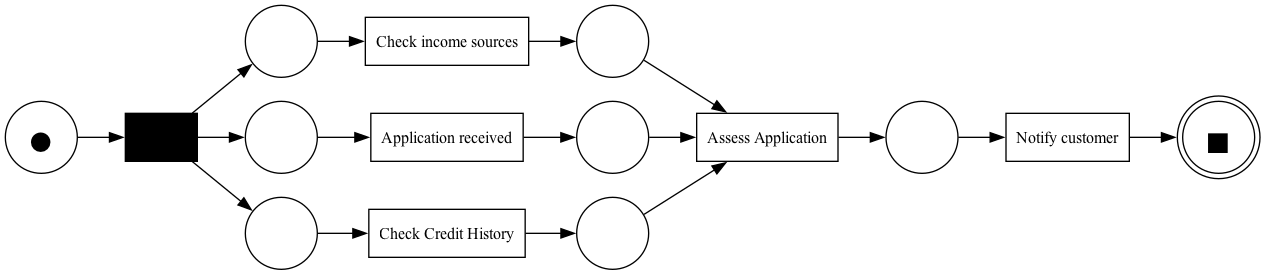

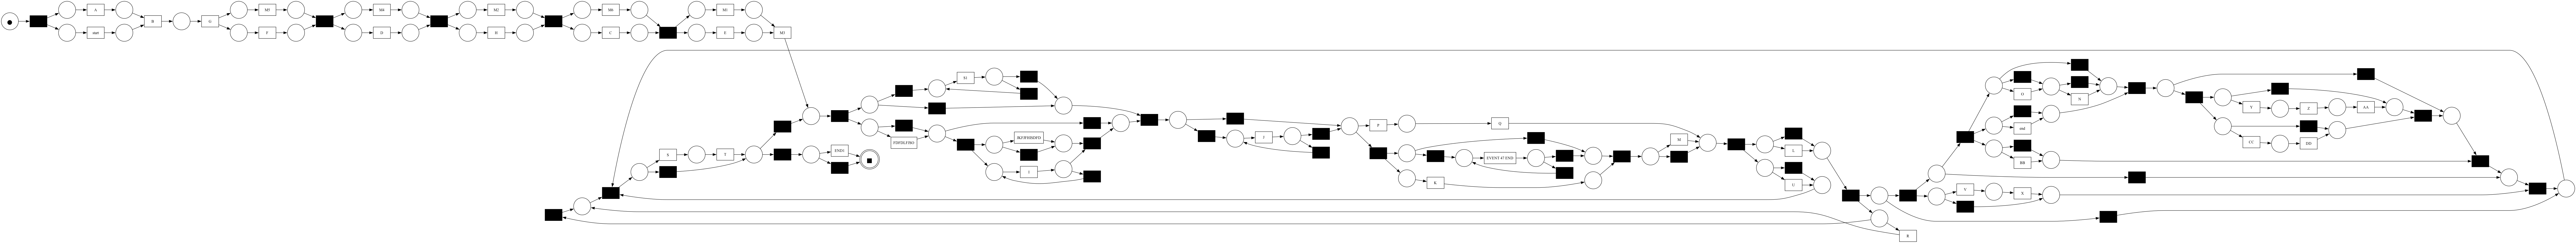

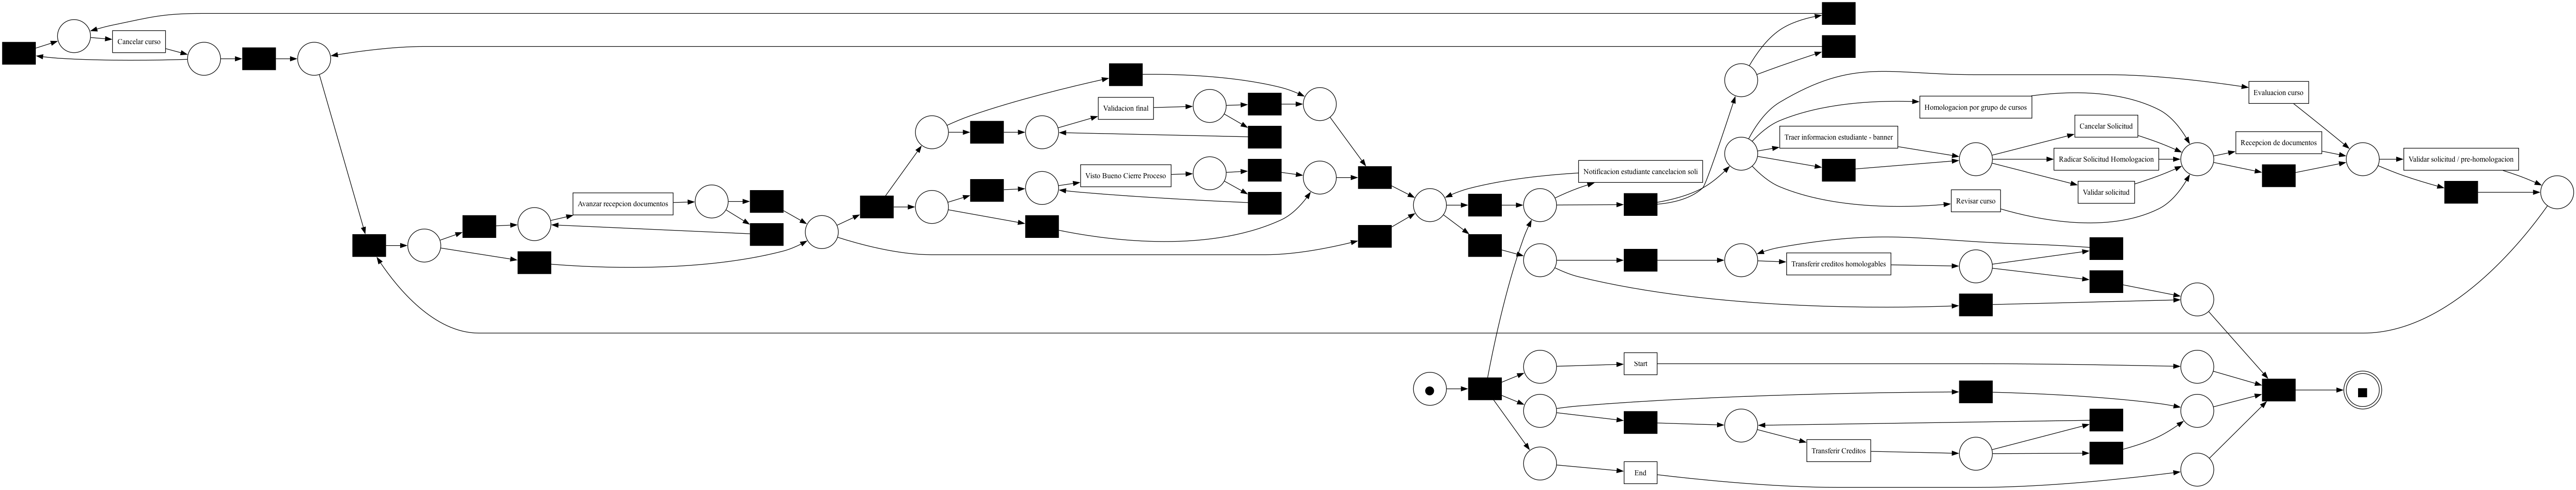

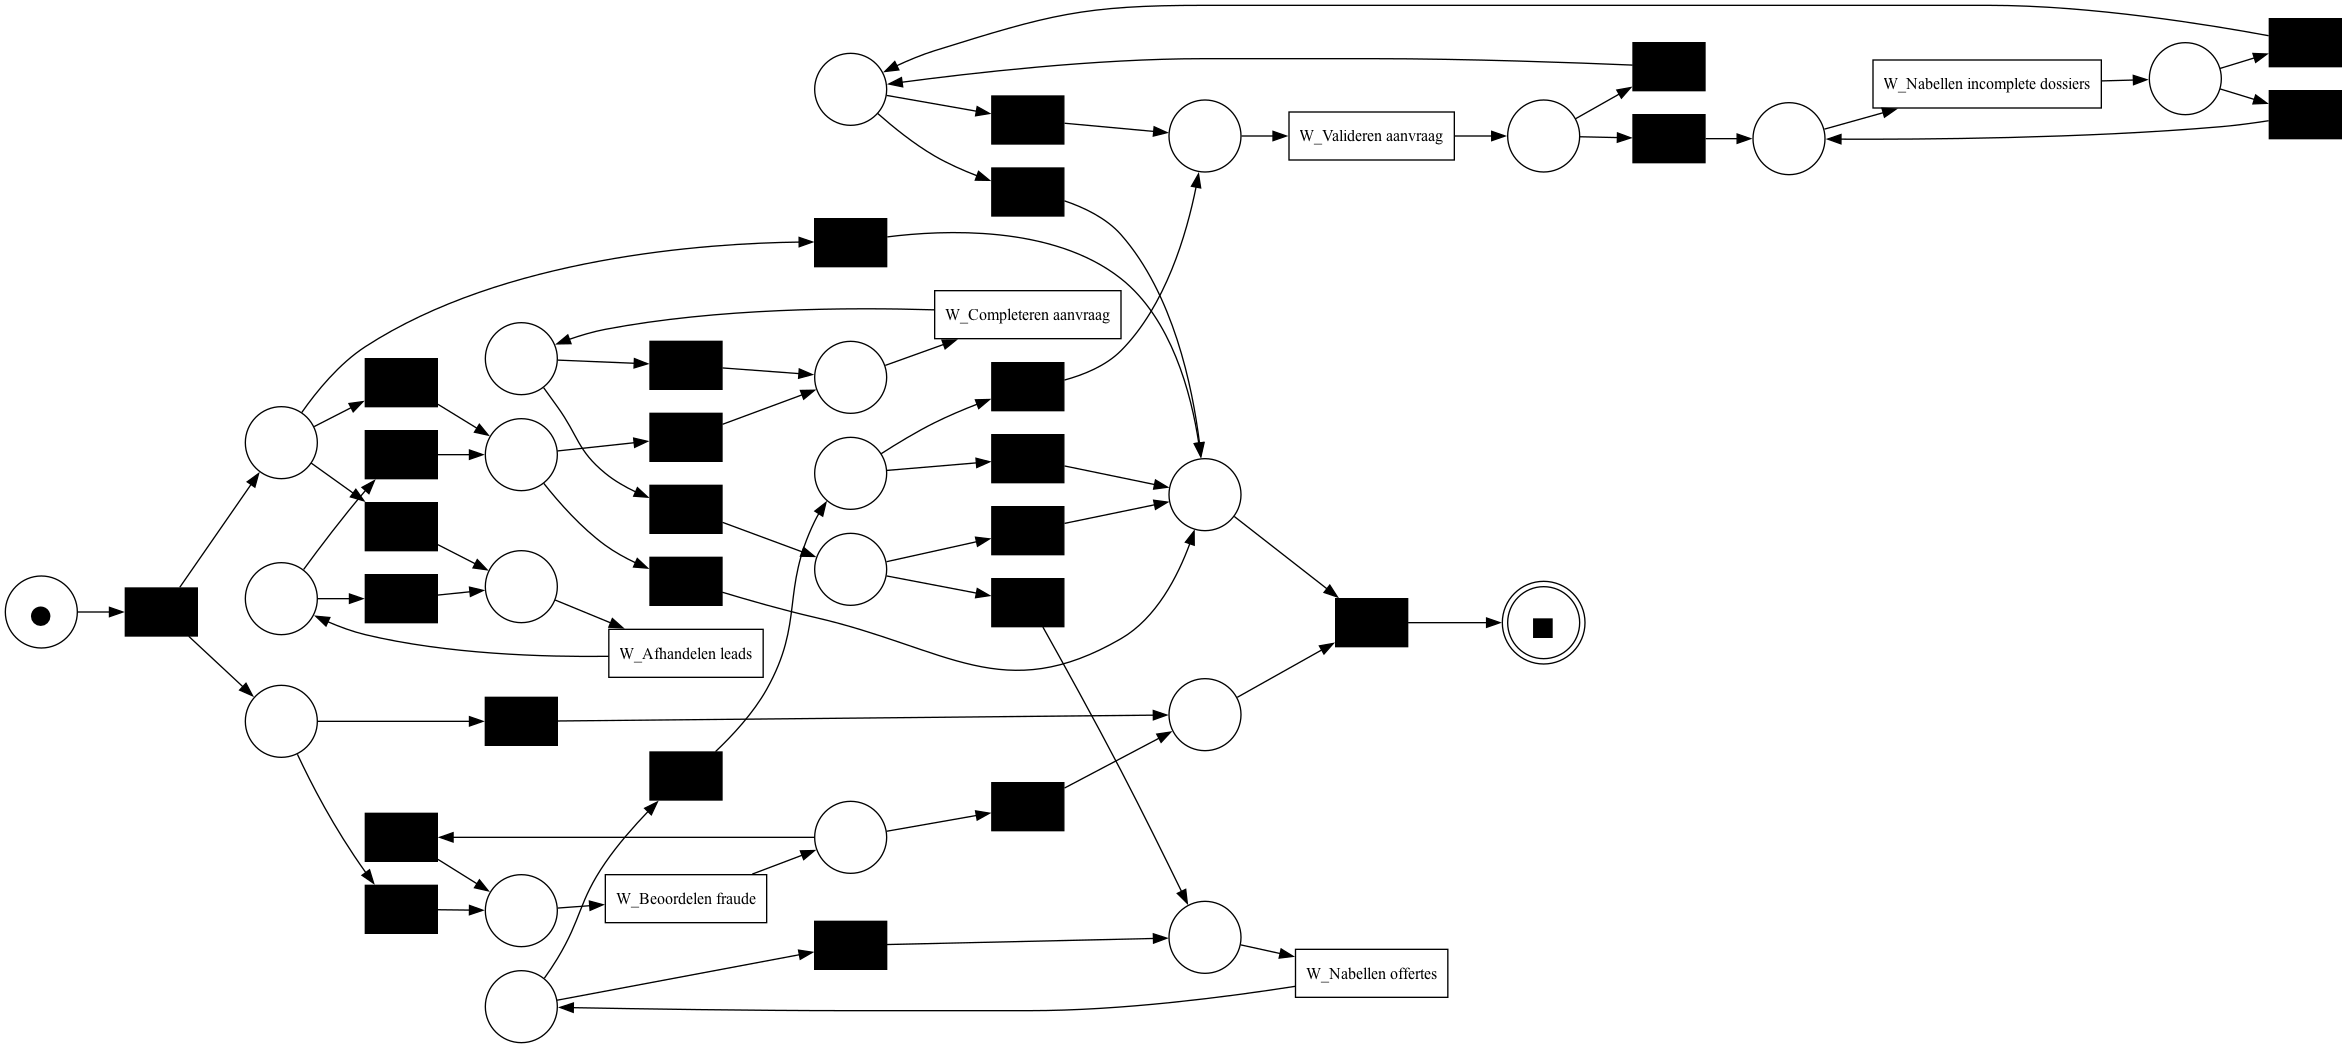

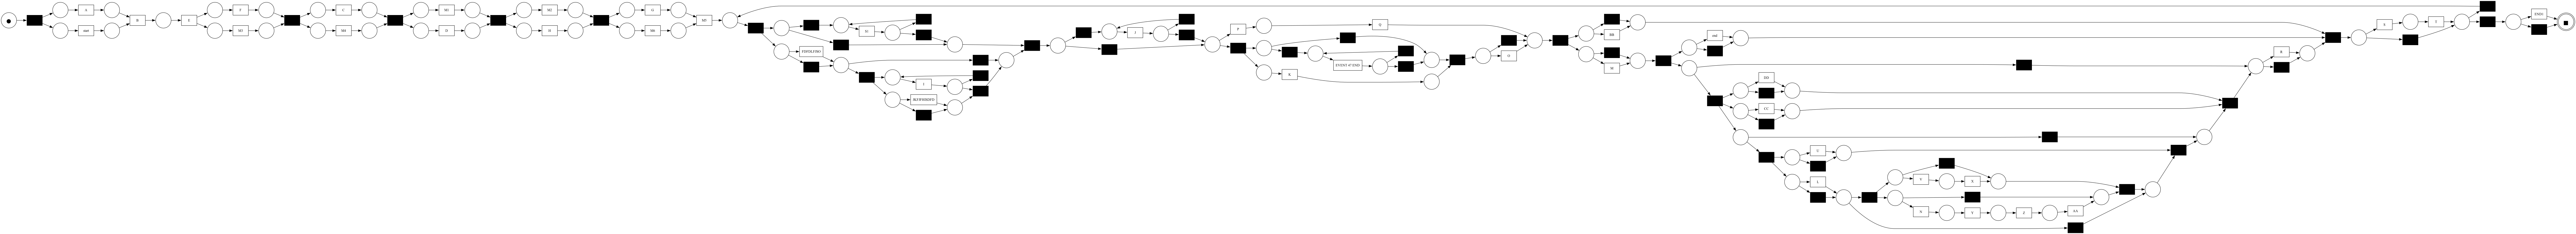

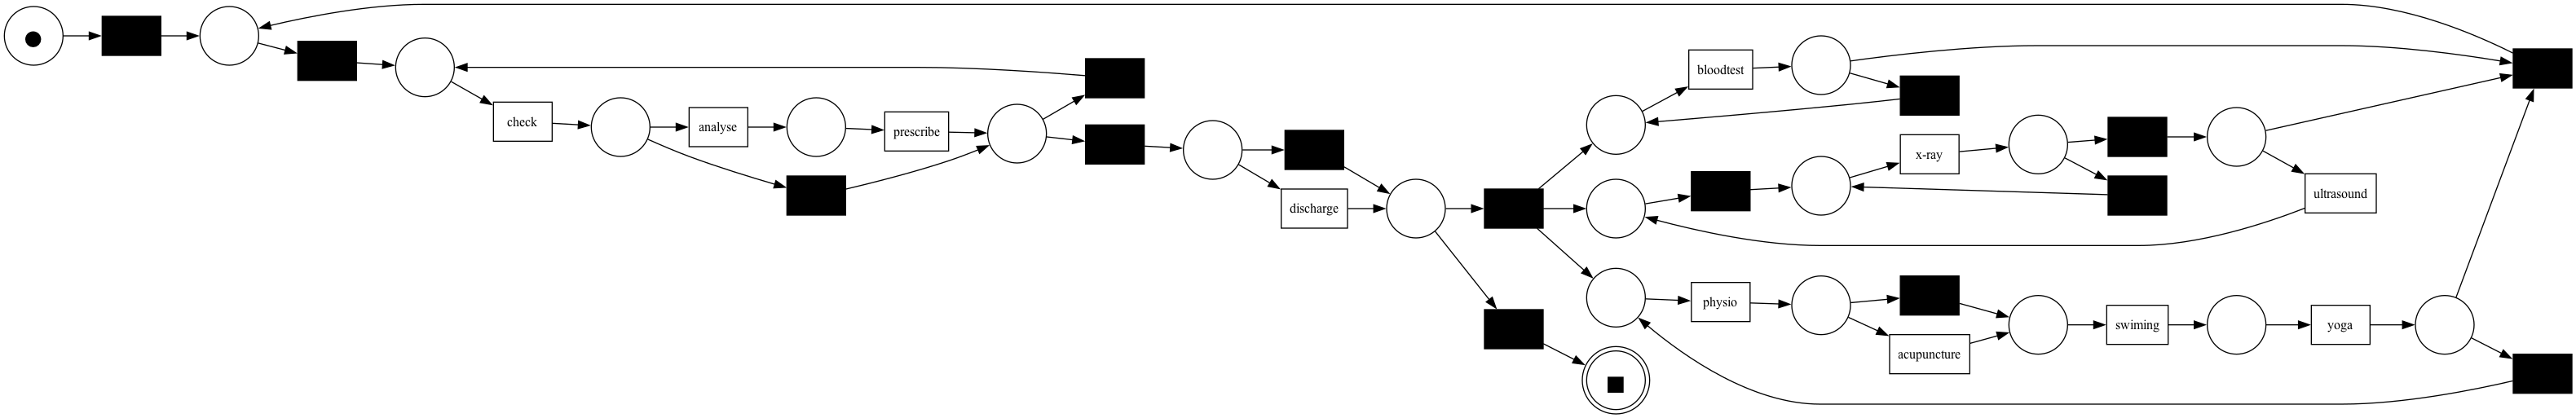

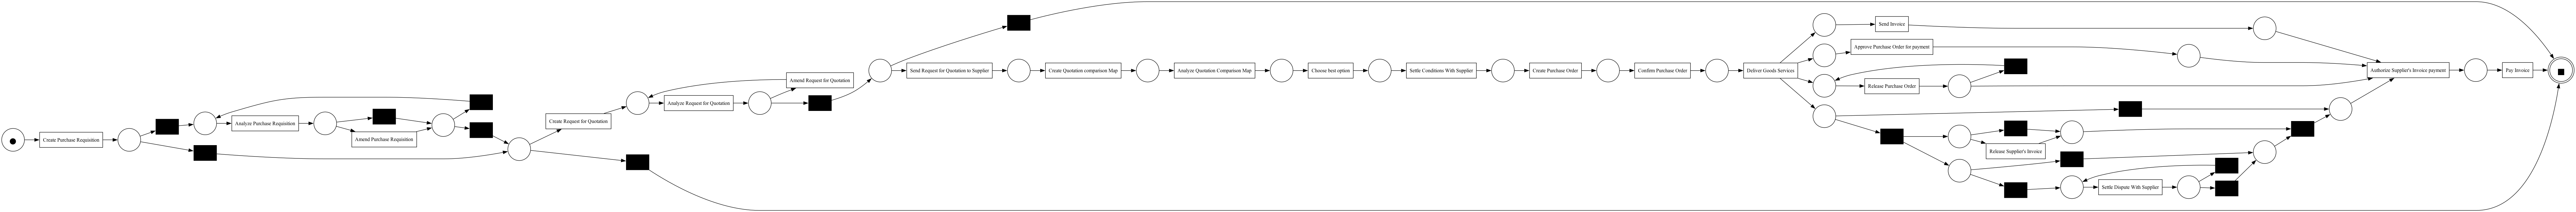

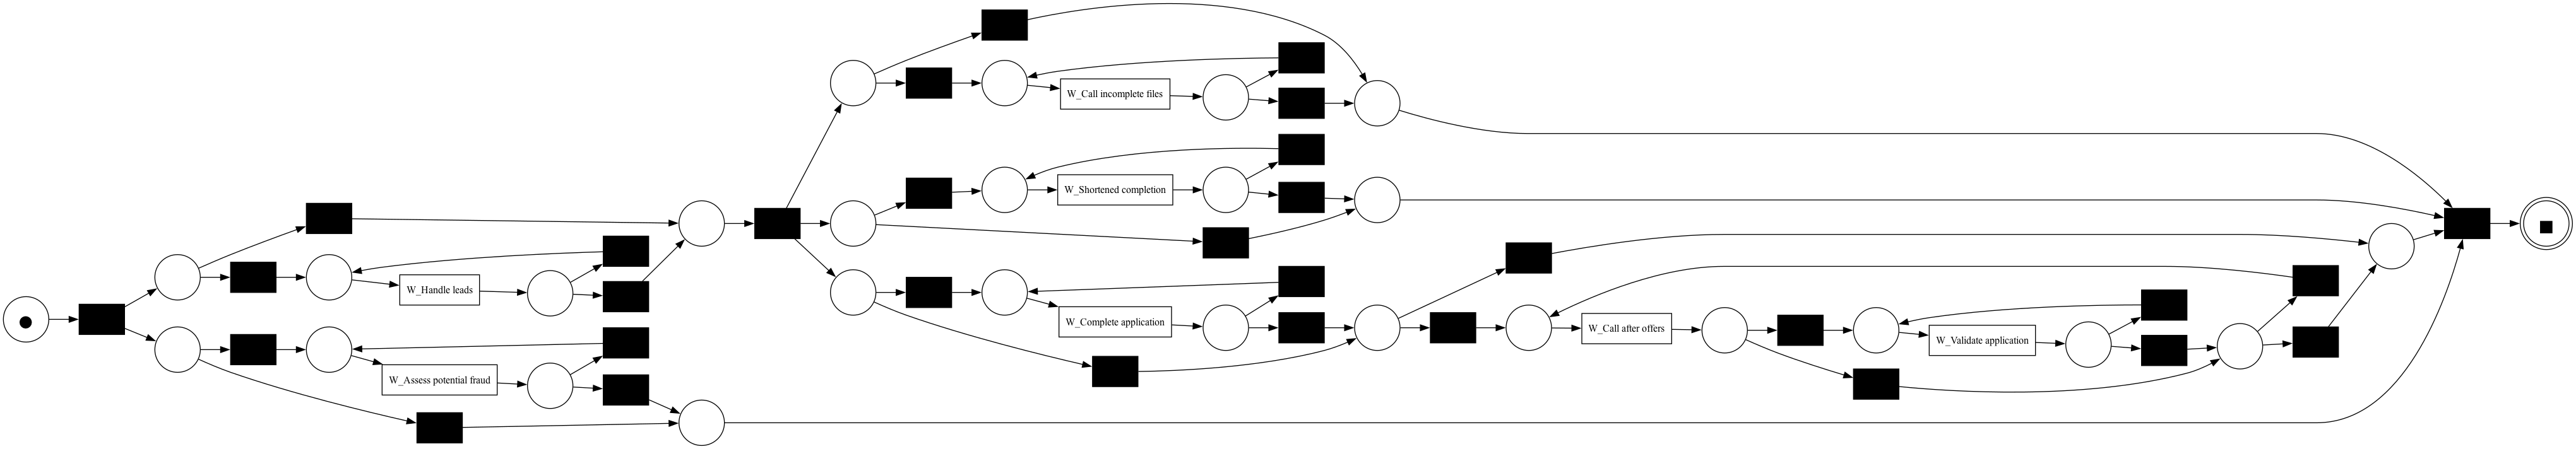

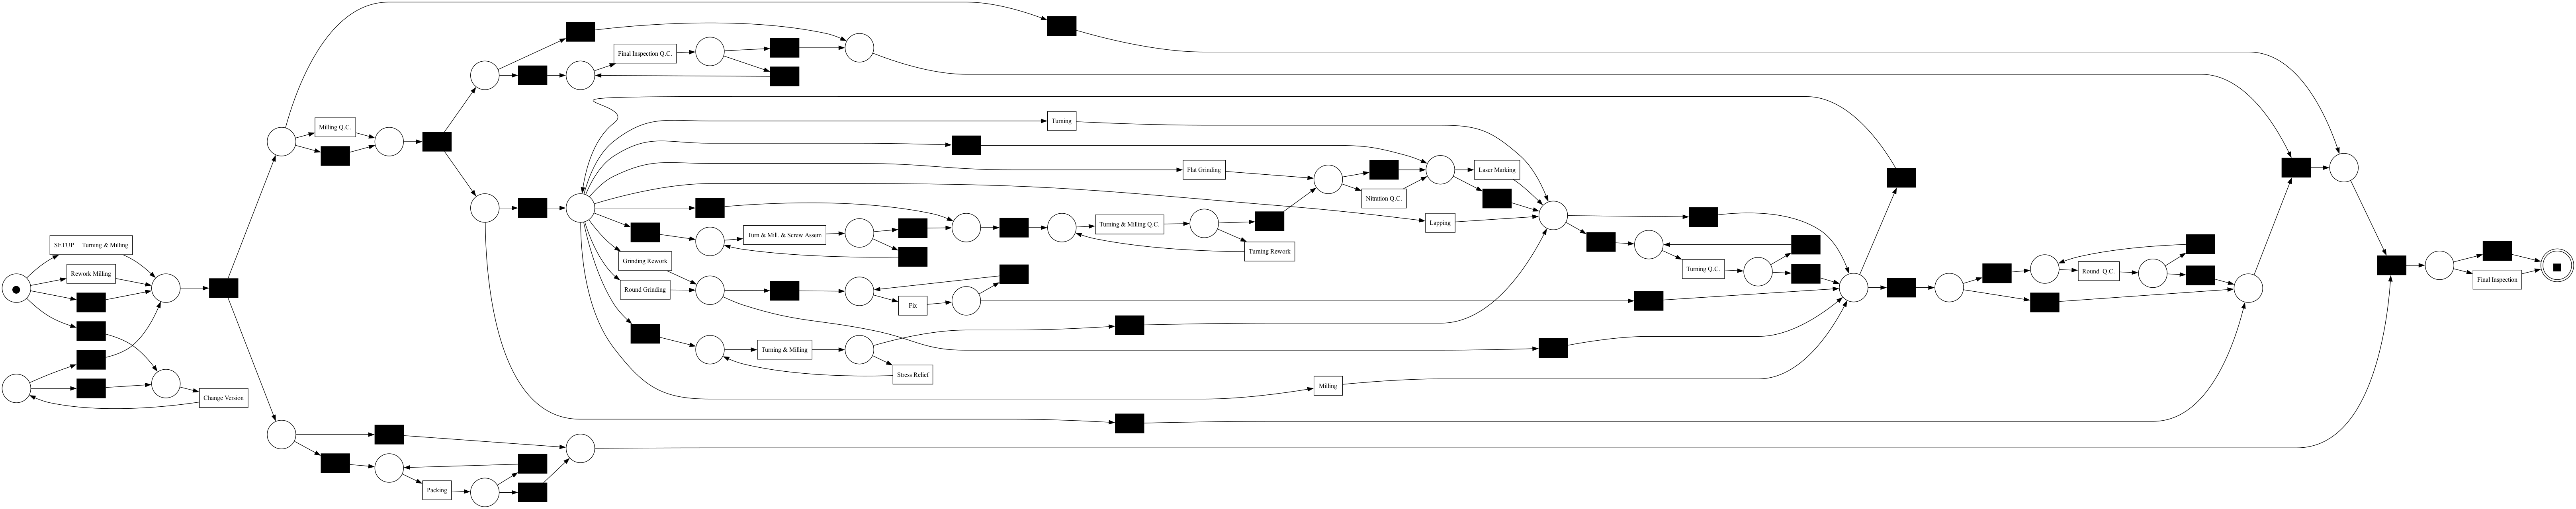

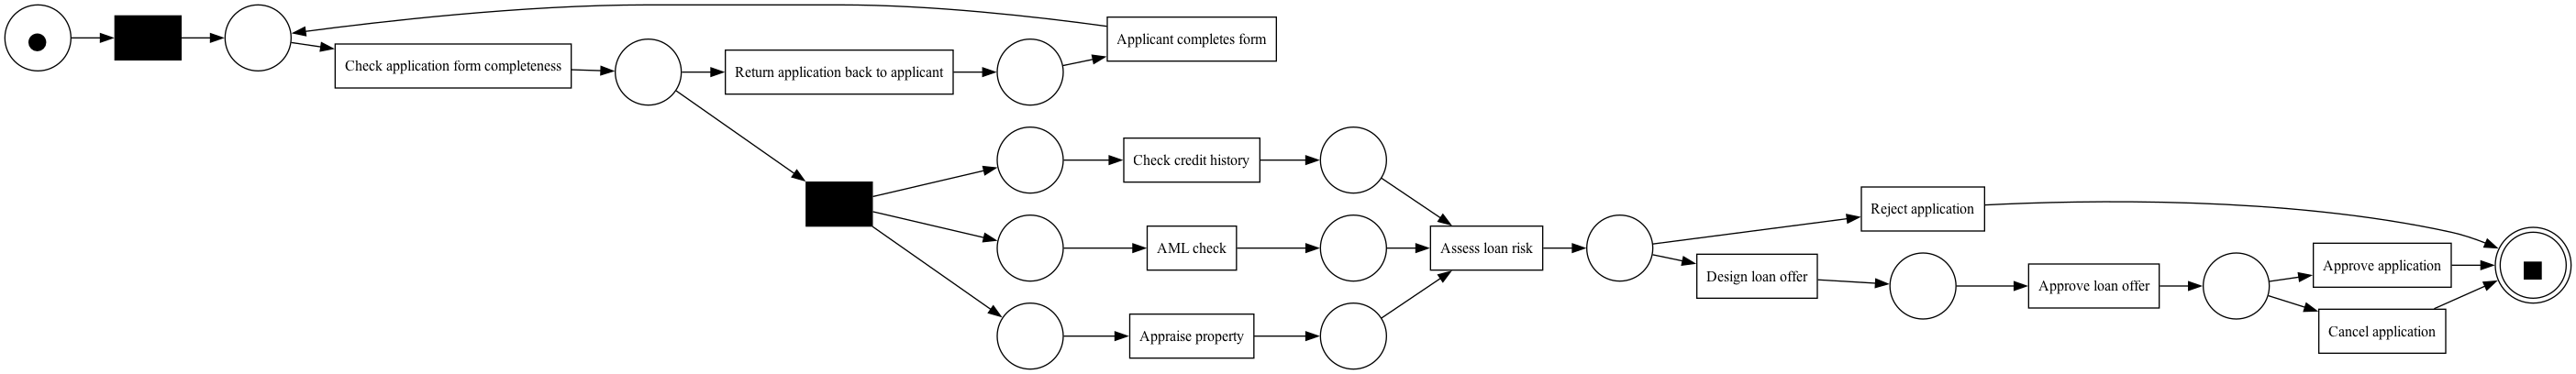

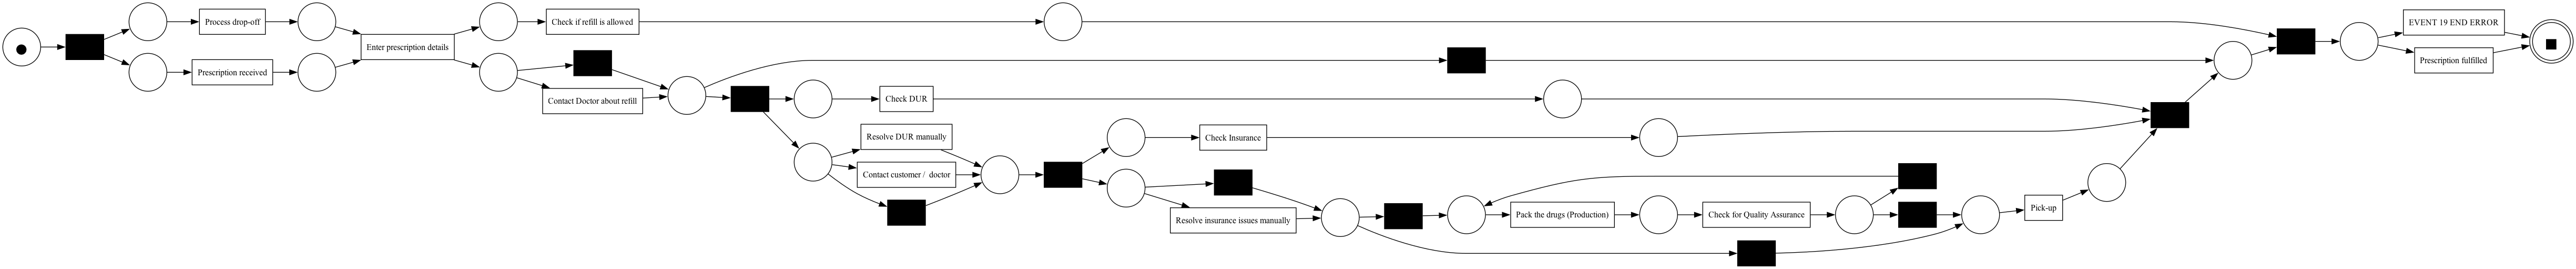

In [6]:
for log in logs:
    # generate full petri net
    net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(
                                            log=log, 
                                            noise_threshold=0.0,
                                            timestamp_key='start_timestamp',)
    gviz = pn_visualizer.apply(net, initial_marking, final_marking)
    pn_visualizer.view(gviz)